Performance Metrics:
Sharpe Ratio:  10.10
Sortino Ratio: 28.45
Max Drawdown:  0.96
Calmar Ratio:  65.18


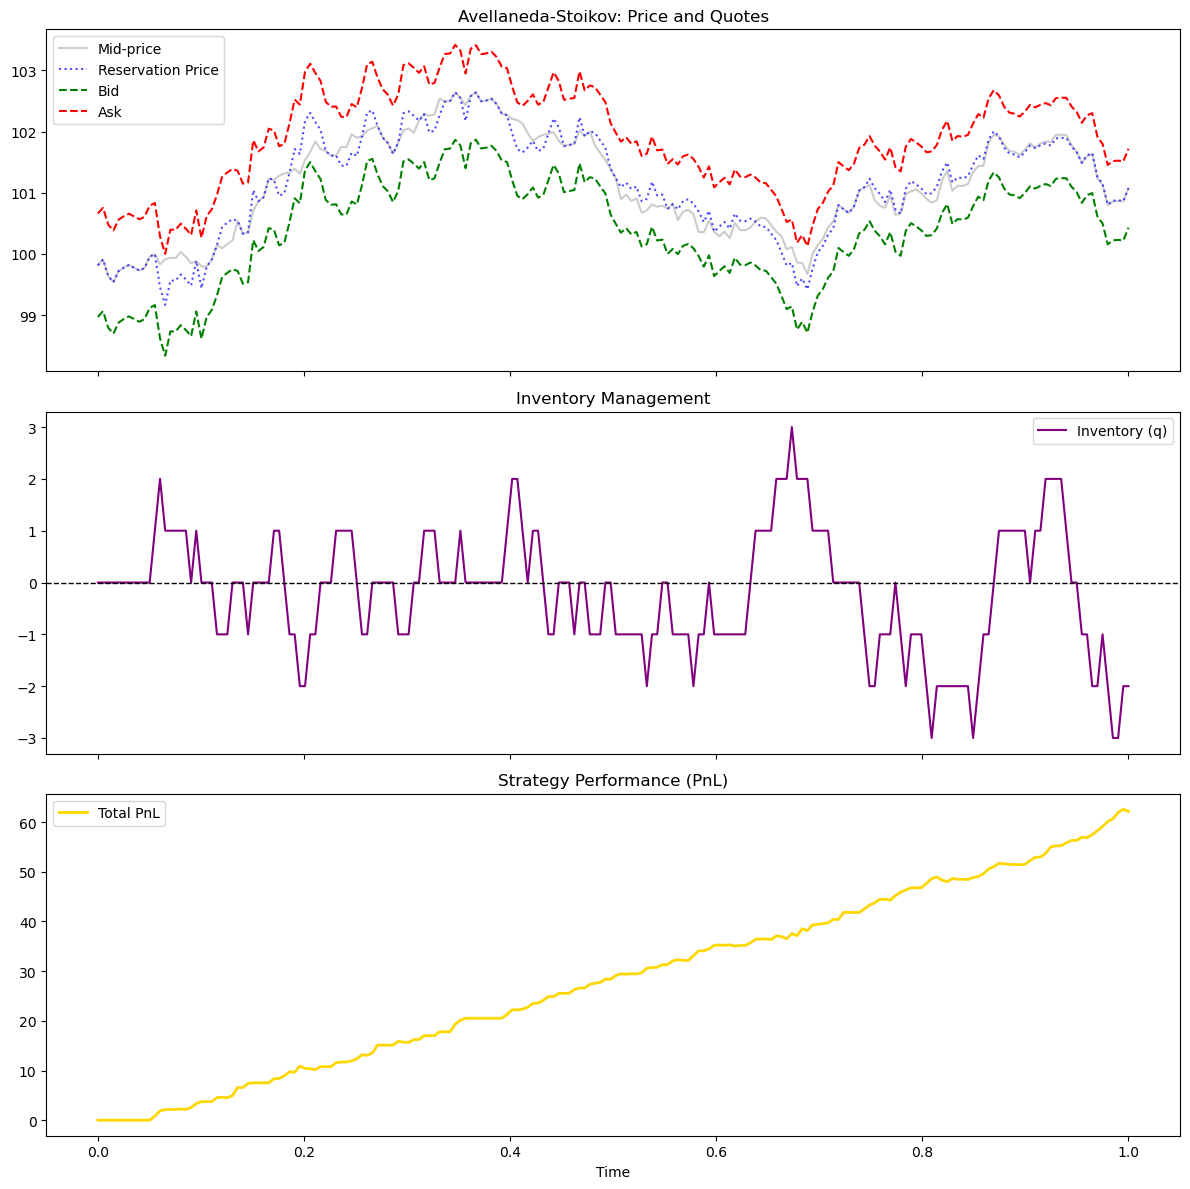

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Parameters
S0 = 100.0          
T = 1.0             
dt = 0.005          
sigma = 2.0         
gamma = 0.1         
kappa = 1.5         
A = 140.0           
q0 = 0              

n_steps = int(T / dt)
time = np.linspace(0, T, n_steps)

# 2. Storage
midprice = np.zeros(n_steps)
inventory = np.zeros(n_steps)
pnl = np.zeros(n_steps)
res_price = np.zeros(n_steps)
bid_quotes = np.zeros(n_steps)
ask_quotes = np.zeros(n_steps)

# 3. Simulation Loop
s = S0
q = q0
cash = 0

for i in range(n_steps):
    t = time[i]
    s += sigma * np.sqrt(dt) * np.random.normal()
    midprice[i] = s
    
    # Avellaneda-Stoikov Logic
    r = s - q * gamma * (sigma**2) * (T - t)
    res_price[i] = r
    
    spread = (2 / gamma) * np.log(1 + (gamma / kappa)) + (gamma * (sigma**2) * (T - t))
    
    bid = r - spread / 2
    ask = r + spread / 2
    bid_quotes[i], ask_quotes[i] = bid, ask
    
    # Corrected Fills: Poisson CDF probability P(X > 0)
    lambda_bid = A * np.exp(-kappa * (s - bid))
    lambda_ask = A * np.exp(-kappa * (ask - s))
    
    prob_bid = 1 - np.exp(-lambda_bid * dt)
    prob_ask = 1 - np.exp(-lambda_ask * dt)
    
    if np.random.random() < prob_bid:
        q += 1
        cash -= bid
    if np.random.random() < prob_ask:
        q -= 1
        cash += ask
        
    inventory[i] = q
    pnl[i] = cash + q * s

# 4. Performance Metrics Calculation
returns = np.diff(pnl)
# Annualizing assuming T=1 is one day (252 trading days)
ann_factor = 252 
mu = np.mean(returns) * n_steps
vol = np.std(returns) * np.sqrt(n_steps)

# Sharpe Ratio (Assuming 0 risk-free rate)
sharpe = mu / vol if vol != 0 else 0

# Sortino Ratio (Downside deviation)
downside_returns = returns[returns < 0]
downside_std = np.std(downside_returns) * np.sqrt(n_steps)
sortino = mu / downside_std if downside_std != 0 else 0

# Max Drawdown
running_max = np.maximum.accumulate(pnl)
drawdown = running_max - pnl
max_dd = np.max(drawdown)

# Calmar Ratio
calmar = mu / max_dd if max_dd != 0 else 0

print(f"Performance Metrics:\n{'='*20}")
print(f"Sharpe Ratio:  {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown:  {max_dd:.2f}")
print(f"Calmar Ratio:  {calmar:.2f}")

# 5. Visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Chart 1: Price and Quotes
ax1.plot(time, midprice, label="Mid-price", color="gray", alpha=0.4)
ax1.plot(time, res_price, label="Reservation Price", color="blue", linestyle=":", alpha=0.7)
ax1.plot(time, bid_quotes, label="Bid", color="green", linestyle="--")
ax1.plot(time, ask_quotes, label="Ask", color="red", linestyle="--")
ax1.set_title("Avellaneda-Stoikov: Price and Quotes")
ax1.legend()

# Chart 2: Inventory
ax2.plot(time, inventory, label="Inventory (q)", color="purple")
ax2.axhline(0, color='black', lw=1, ls='--')
ax2.set_title("Inventory Management")
ax2.legend()

# Chart 3: PnL
ax3.plot(time, pnl, label="Total PnL", color="gold", lw=2)
ax3.set_title("Strategy Performance (PnL)")
ax3.set_xlabel("Time")
ax3.legend()

plt.tight_layout()
plt.show()

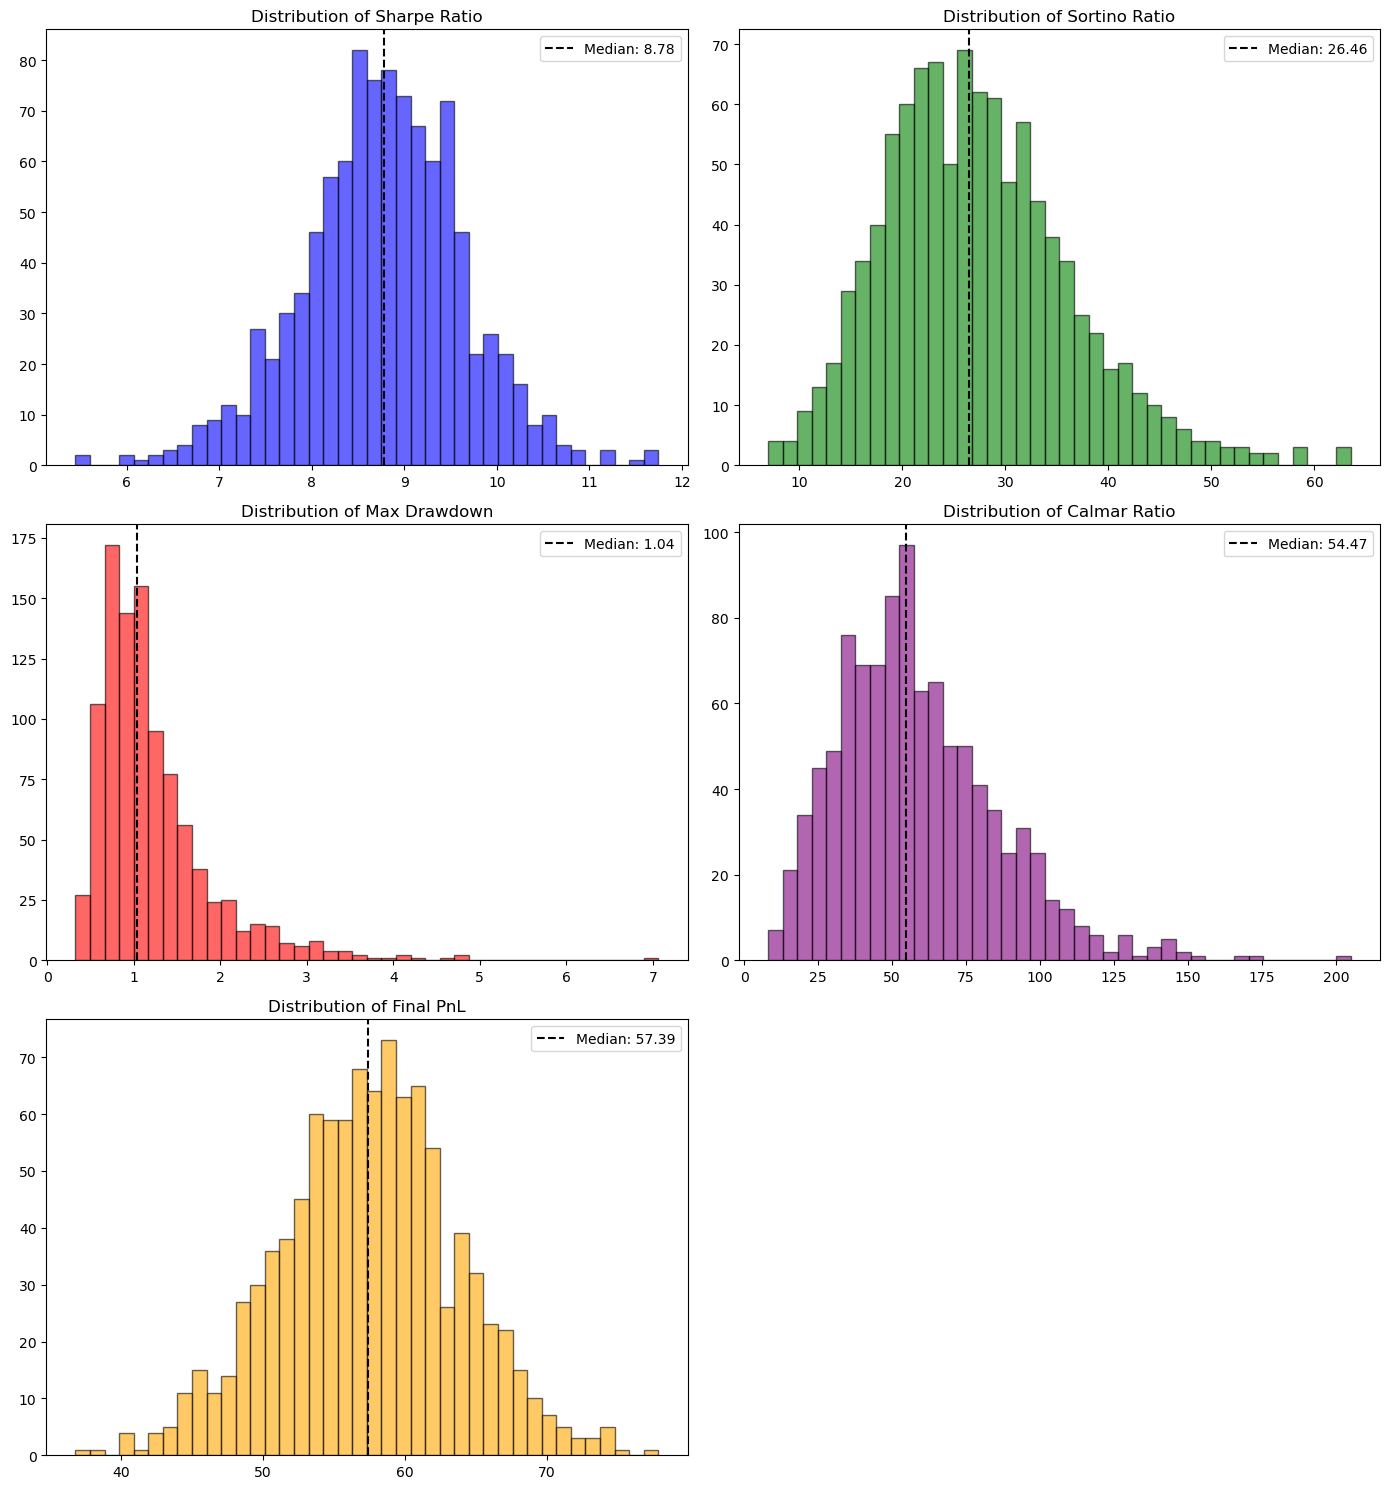

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Configuration & Parameters (Keeping original settings)
N_SIMS = 1000
S0, T, dt = 100.0, 1.0, 0.005
sigma, gamma, kappa, A = 2.0, 0.1, 1.5, 140.0
n_steps = int(T / dt)

def run_single_simulation():
    s, q, cash = S0, 0, 0
    pnl = np.zeros(n_steps)
    
    for i in range(n_steps):
        t = i * dt
        s += sigma * np.sqrt(dt) * np.random.normal()
        
        # AS Logic: Reservation Price & Spread
        r = s - q * gamma * (sigma**2) * (T - t)
        spread = (2 / gamma) * np.log(1 + (gamma / kappa)) + (gamma * (sigma**2) * (T - t))
        
        bid, ask = r - spread / 2, r + spread / 2
        
        # Fill Probabilities (Exponential CDF)
        prob_bid = 1 - np.exp(-(A * np.exp(-kappa * (s - bid))) * dt)
        prob_ask = 1 - np.exp(-(A * np.exp(-kappa * (ask - s))) * dt)
        
        if np.random.random() < prob_bid:
            q += 1; cash -= bid
        if np.random.random() < prob_ask:
            q -= 1; cash += ask
            
        pnl[i] = cash + q * s
        
    # Metric Calculations
    returns = np.diff(pnl)
    mu = np.mean(returns) * n_steps
    vol = np.std(returns) * np.sqrt(n_steps)
    
    sharpe = mu / vol if vol != 0 else 0
    
    downside_std = np.std(returns[returns < 0]) * np.sqrt(n_steps)
    sortino = mu / downside_std if downside_std != 0 else 0
    
    max_dd = np.max(np.maximum.accumulate(pnl) - pnl)
    calmar = mu / max_dd if max_dd != 0 else 0
    
    # Returning metrics + final PnL value
    return sharpe, sortino, max_dd, calmar, pnl[-1]

# 2. Execute Monte Carlo
results = np.array([run_single_simulation() for _ in range(N_SIMS)])
sharpes, sortinos, max_dds, calmars, final_pnls = results.T

# 3. Visualization of Distributions (Updated to 3x2 Grid)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
metrics = [
    (sharpes, 'Sharpe Ratio', 'blue'),
    (sortinos, 'Sortino Ratio', 'green'),
    (max_dds, 'Max Drawdown', 'red'),
    (calmars, 'Calmar Ratio', 'purple'),
    (final_pnls, 'Final PnL', 'orange')
]

# Plot each metric
for i, (data, title, color) in enumerate(metrics):
    ax = axes.flatten()[i]
    ax.hist(data, bins=40, color=color, alpha=0.6, edgecolor='black')
    ax.axvline(np.median(data), color='black', linestyle='--', label=f'Median: {np.median(data):.2f}')
    ax.set_title(f'Distribution of {title}')
    ax.legend()

# Remove the empty subplot (6th plot)
fig.delaxes(axes[2,1])

plt.tight_layout()
plt.show()